# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.
Задача — установить параметры объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://*******/real_estate_data.csv', sep='\t')
data.info()
dataset_length = len(data)
display(data.head())
print(dataset_length)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


23699


В данном датасете 23699 строк, достаточно много пропусков, но, возможно не все пропуски необходимо устранять

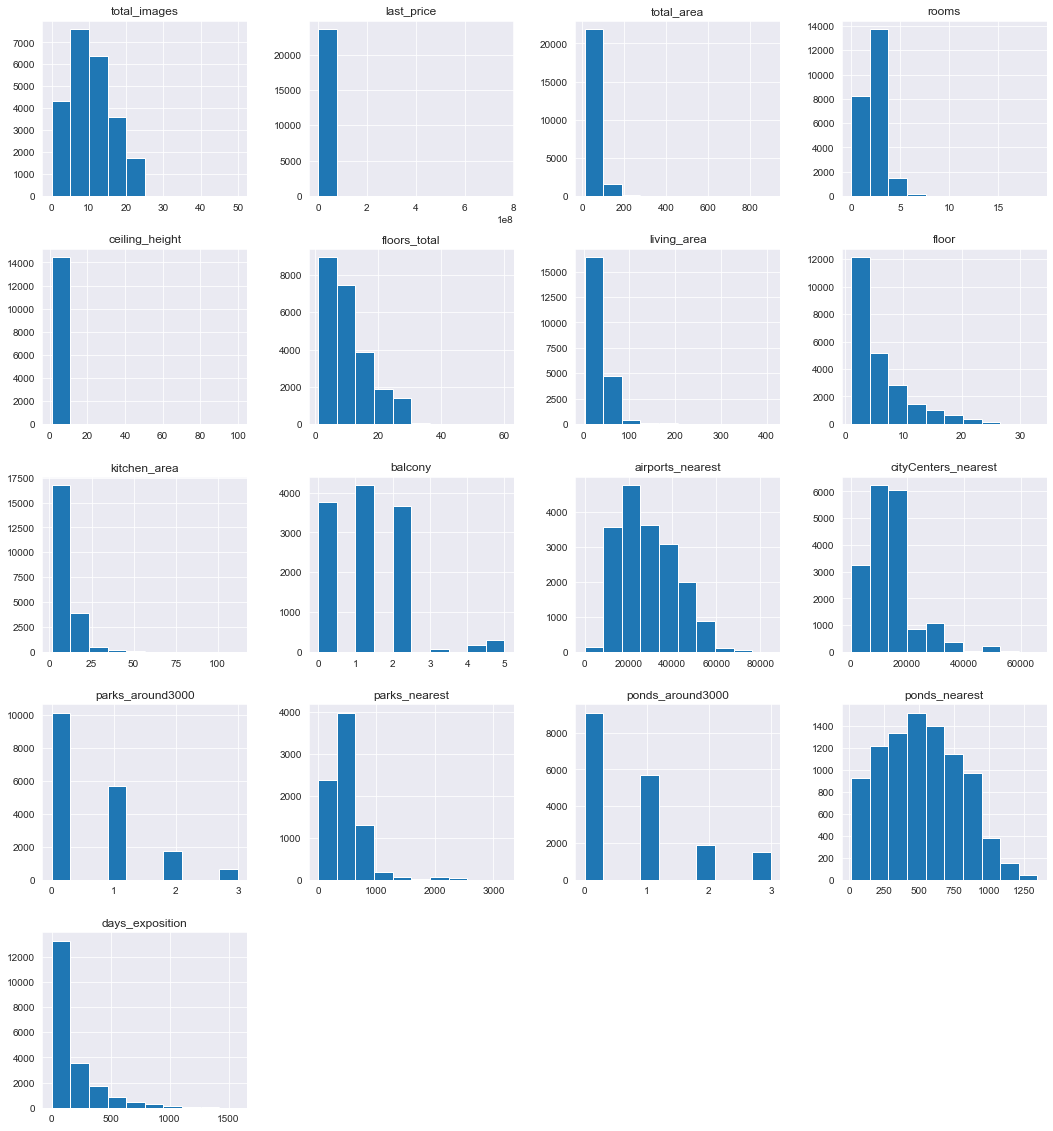

In [3]:
data.hist(figsize=(18, 20));

### Предобработка данных

In [4]:
#подсчитаем количество пропусков и дубликатов
display(data.isna().sum())
print('Дубликатов:', data.duplicated().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Дубликатов: 0


В данном датасете обнаружены пропуски в столбцах:
   - ceiling_height
   - floors_total
   - living_area
   - is_apartment
   - kitchen_area
   - balkony
   - locality_name
   - airports_nearest
   - cityCenters_nearest
   - parks_around3000
   - parks_nearest
   - ponds_around3000
   - ponds_nearest
   - days_exposition

In [5]:
data.isna().mean().sort_values(ascending = False)

is_apartment            0.882906
parks_nearest           0.659100
ponds_nearest           0.615596
balcony                 0.486054
ceiling_height          0.387991
airports_nearest        0.233850
cityCenters_nearest     0.232879
ponds_around3000        0.232837
parks_around3000        0.232837
days_exposition         0.134225
kitchen_area            0.096122
living_area             0.080299
floors_total            0.003629
locality_name           0.002068
total_images            0.000000
last_price              0.000000
studio                  0.000000
floor                   0.000000
rooms                   0.000000
first_day_exposition    0.000000
total_area              0.000000
open_plan               0.000000
dtype: float64

Заменим пропуски:
 - в количестве балконов на "0", проверим
 - в столбце ceiling_height (высота потолков) на медианное значение (среднее значение искажают ошибки в данных, например высота потолков в 19м)
 - невозможно предсказать город, поэтому заменим пропуски на значение unknown
 - невозможно предсказать этажность домов, оставим пропуски (не будем заменять на 'unknown'), чтобы не мешать вычислениям в дальнейшем
 - жилую площадь и площадь кухни посчитаем исходя из медианного значения для квартир с таким же количеством комнат
 - в колонке 'kitchen_area' осталось еще 197 пустых значений - это все квартиры с нулевым количеством комнат (студии), там невозможно посчитать площадь кухни отдельно от жилой площади
 - столбцы с ...nearest и ...around оставим с пропусками



In [6]:
data['balcony'] = data['balcony'].fillna(0)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['locality_name']=data['locality_name'].fillna('unknown')

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
for area in ['living_area', 'kitchen_area']:
    for item in data['rooms'].unique():
        data.loc[(data['rooms'] == item) & (data[area].isna()), area] = \
            data.loc[data['rooms'] == item, area].median()

display(data.isna().sum())
#проверим, какие значения остались в пропусках kitchen_area
display(data.loc[data['kitchen_area'].isna()])
data['kitchen_area'] = data['kitchen_area'].fillna(0)

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area              197
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000.0,27.00,2017-03-30T00:00:00,0,2.65,24.0,15.50,2,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,181.0
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.65,14.0,17.00,1,NaN,...,NaN,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,2.65,17.0,24.75,4,NaN,...,NaN,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.65,26.0,24.30,19,NaN,...,NaN,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
608,2,1850000.0,25.00,2019-02-20T00:00:00,0,2.65,10.0,18.00,7,NaN,...,NaN,0.0,посёлок Шушары,NaN,NaN,NaN,NaN,NaN,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000.0,26.00,2017-09-01T00:00:00,0,2.65,25.0,18.00,16,NaN,...,NaN,0.0,Санкт-Петербург,11405.0,13222.0,0.0,NaN,1.0,623.0,14.0
23442,0,2500000.0,27.70,2017-09-28T00:00:00,0,2.65,24.0,18.00,4,NaN,...,NaN,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,4.0
23554,15,3350000.0,26.00,2018-09-07T00:00:00,0,2.65,19.0,18.00,8,NaN,...,NaN,0.0,Санкт-Петербург,18090.0,17092.0,0.0,NaN,2.0,112.0,31.0
23592,10,1450000.0,29.00,2017-11-11T00:00:00,0,2.65,9.0,18.00,8,NaN,...,NaN,2.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,82.0


К пропускам данных в этих колонках мог привести человеческий фактор, например поля могли быть не заполнены человеком, добавляющим объект недвижимости. Также существуют случайные пропуски, такие как площадь кухни в квартире с нулем комнат, такие пропуски зависят от значений другого столбца.



Преобразуем колонку 'is_apartment' в тип boolean, вместо object, а также количество балконов (колонка balkony) в целочисленный тип int64

In [8]:
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [9]:
display(sorted(data['locality_name'].unique()))

['unknown',
 'Бокситогорск',
 'Волосово',
 'Волхов',
 'Всеволожск',
 'Выборг',
 'Высоцк',
 'Гатчина',
 'Зеленогорск',
 'Ивангород',
 'Каменногорск',
 'Кингисепп',
 'Кириши',
 'Кировск',
 'Колпино',
 'Коммунар',
 'Красное Село',
 'Кронштадт',
 'Кудрово',
 'Лодейное Поле',
 'Ломоносов',
 'Луга',
 'Любань',
 'Мурино',
 'Никольское',
 'Новая Ладога',
 'Отрадное',
 'Павловск',
 'Петергоф',
 'Пикалёво',
 'Подпорожье',
 'Приморск',
 'Приозерск',
 'Пушкин',
 'Санкт-Петербург',
 'Светогорск',
 'Сертолово',
 'Сестрорецк',
 'Сланцы',
 'Сосновый Бор',
 'Сясьстрой',
 'Тихвин',
 'Тосно',
 'Шлиссельбург',
 'городской поселок Большая Ижора',
 'городской поселок Янино-1',
 'городской посёлок Будогощь',
 'городской посёлок Виллози',
 'городской посёлок Лесогорский',
 'городской посёлок Мга',
 'городской посёлок Назия',
 'городской посёлок Новоселье',
 'городской посёлок Павлово',
 'городской посёлок Рощино',
 'городской посёлок Свирьстрой',
 'городской посёлок Советский',
 'городской посёлок Фёдоровское

In [10]:
data['locality_name_filtered'] = data['locality_name'].str.lower()
data['locality_name_filtered'] = data['locality_name_filtered'].str.replace('ё', 'е', regex=True)
for item in ['городской поселок', 'деревня', 'коттеджный поселок', 'поселок городского типа', 'поселок станции', 'садоводческое некоммерческое товарищество', 'садовое товарищество', 'поселок', 'село']:
    data['locality_name_filtered'] = data['locality_name_filtered'].str.replace(item, '')
data['locality_name_filtered'] = data['locality_name_filtered'].str.lstrip()

display(sorted(data['locality_name_filtered'].unique()))

['unknown',
 'агалатово',
 'александровская',
 'алексеевка',
 'аннино',
 'аро',
 'барышево',
 'батово',
 'бегуницы',
 'белогорка',
 'белоостров',
 'бокситогорск',
 'большая вруда',
 'большая ижора',
 'большая пустомержа',
 'большие колпаны',
 'большое рейзино',
 'большой сабск',
 'бор',
 'борисова грива',
 'бугры',
 'будогощь',
 'ваганово',
 'важины',
 'вартемяги',
 'вахнова кара',
 'вещево',
 'виллози',
 'вознесенье',
 'возрождение',
 'войсковицы',
 'войскорово',
 'володарское',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'вырица',
 'выскатка',
 'высокоключевой',
 'высоцк',
 'гаврилово',
 'гарболово',
 'гатчина',
 'гладкое',
 'глажево',
 'глебычево',
 'глинка',
 'гончарово',
 'горбунки',
 'гостилицы',
 'громово',
 'дзержинского',
 'дружная горка',
 'дружноселье',
 'дубровка',
 'елизаветино',
 'ефимовский',
 'жил',
 'жилгородок',
 'житково',
 'заводской',
 'заклинье',
 'заневка',
 'запорожское',
 'зеленогорск',
 'зимитицы',
 'ивангород',
 'извара',
 'ильичево',
 'имени морозова'

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

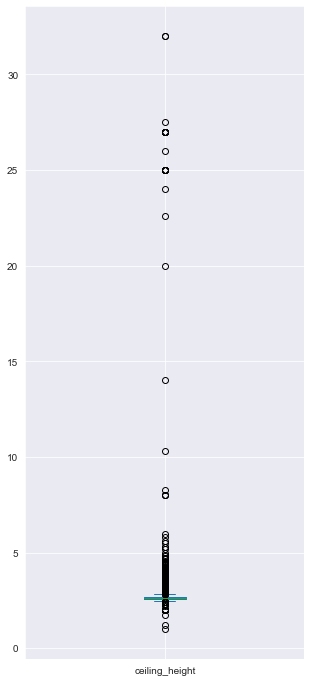

In [11]:
display (data['ceiling_height'].describe())
# data['ceiling_height'].plot(kind='box' ,grid=True, figsize = (5, 12))
data.loc[data['ceiling_height'] < 70,'ceiling_height'].plot(kind='box' ,grid=True, figsize = (5, 12));

In [12]:
data.loc[(data['ceiling_height'] <= 1.9) | (data['ceiling_height'] >= 5) & (data['ceiling_height'] < 15) | (data['ceiling_height'] > 40), 'ceiling_height'] = data['ceiling_height'].median()
data.loc[(data['ceiling_height'] >= 19) & (data['ceiling_height'] < 40), 'ceiling_height'] /= 10
data['ceiling_height'].describe()


count    23699.000000
mean         2.695912
std          0.215138
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.900000
Name: ceiling_height, dtype: float64

Изучив результаты describe и построив график можем убедиться, что медианная высота потолков - 2.65м, что выглядит убедительно, при этом есть масса значений около 20-30м, возможно это на самом деле высота потолков от 2.0 до 3.0 метров, также можем наблюдать явные ошибочные значения (высота потолков 1м, от 5 до 15м, выше 30 метров) необходимо очистить заведомо неправильные значения и исправить ошибочные

In [13]:
display(data.isna().sum())

total_images                  0
last_price                    0
total_area                    0
first_day_exposition          0
rooms                         0
ceiling_height                0
floors_total                 86
living_area                   0
floor                         0
is_apartment                  0
studio                        0
open_plan                     0
kitchen_area                  0
balcony                       0
locality_name                 0
airports_nearest           5542
cityCenters_nearest        5519
parks_around3000           5518
parks_nearest             15620
ponds_around3000           5518
ponds_nearest             14589
days_exposition            3181
locality_name_filtered        0
dtype: int64

In [14]:
display(data.describe())
# удалим редкие значения в столбце с количеством комнат
# data['rooms'].plot(kind='box' ,grid=True, figsize = (5, 12))
# display(data['rooms'].value_counts())
data['rooms'] = data['rooms'].where(data['rooms'] < 7, None)
data['total_images'] = data['total_images'].where(data['total_images'] < 30, None)
data['last_price'] = data['last_price'].where(data['last_price'] < 1.7*(10**8), None)
data['total_area'] = data['total_area'].where(data['total_area'] < 300, None)
data['living_area'] = data['living_area'].where(data['living_area'] < 150, None)
data['kitchen_area'] = data['kitchen_area'].where(data['kitchen_area'] < 60, None)
data = data.dropna(subset=['rooms','total_images','last_price','total_area', 'living_area', 'kitchen_area'])
# display(data.isna().sum())

# проверка этажей
display(data.loc[(data['floor']>data['floors_total'])])

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,23699.000000,23699.000000,23699.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.695912,10.673824,34.321982,5.892358,10.377514,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.215138,6.597173,21.700627,4.885249,5.720157,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.200000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.040000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.700000,8.000000,11.500000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,4.900000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_filtered


In [15]:
data['total_area'] = pd.to_numeric(data['total_area'])
data['living_area'] = pd.to_numeric(data['living_area'])
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])
data['last_price'] = pd.to_numeric(data['last_price'])

In [16]:
print('Текущая длина датасета: ',len(data))
print(f'Удалено данных: {round(100 - len(data) / dataset_length * 100,2)}%')


Текущая длина датасета:  23487
Удалено данных: 0.89%


Учитывая высокие максимальные значения в ячейках с этажностью зданий и этажом квартиры, проверим нет ли ситуаций, когда этаж квартиры превышает этажность здания, также удалены редкочастотные значения количества комнат

Добавим в таблицу столбец с ценой квадратного метра
Добавим в таблицу день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
Добавим месяц и год публикации объявления, а также тип этажа (первый/последний или другой)
Добавим расстояние до центра города в километрах

In [17]:
data['one_meter_area_price'] = round(data['last_price'] / data['total_area'],1)

In [18]:
data['date_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['weekday_exposition'] = data['date_exposition'].dt.weekday
data['month_exposition'] = data['date_exposition'].dt.month
data['year_exposition'] = data['date_exposition'].dt.year

In [19]:
def gen_floor_type(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['floor_type'] = data.apply(lambda x: gen_floor_type(x['floor'], x['floors_total']), axis=1)

In [20]:
data['kilometres_to_cityCenter'] = round(data['cityCenters_nearest'] / 1000)

In [21]:
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,locality_name_filtered,one_meter_area_price,date_exposition,weekday_exposition,month_exposition,year_exposition,floor_type,kilometres_to_cityCenter
0,20.0,13000000.0,108.0,2019-03-07T00:00:00,3.0,2.70,16.0,51.0,8,True,...,755.0,NaN,санкт-петербург,120370.4,2019-03-07,3,3,2019,другой,16.0
1,7.0,3350000.0,40.4,2018-12-04T00:00:00,1.0,2.65,11.0,18.6,1,True,...,NaN,81.0,шушары,82920.8,2018-12-04,1,12,2018,первый,19.0
2,10.0,5196000.0,56.0,2015-08-20T00:00:00,2.0,2.65,5.0,34.3,4,True,...,574.0,558.0,санкт-петербург,92785.7,2015-08-20,3,8,2015,другой,14.0
3,0.0,64900000.0,159.0,2015-07-24T00:00:00,3.0,2.65,14.0,45.0,9,True,...,234.0,424.0,санкт-петербург,408176.1,2015-07-24,4,7,2015,другой,7.0
4,2.0,10000000.0,100.0,2018-06-19T00:00:00,2.0,3.03,14.0,32.0,13,True,...,48.0,121.0,санкт-петербург,100000.0,2018-06-19,1,6,2018,другой,8.0


### Исследовательский анализ данных

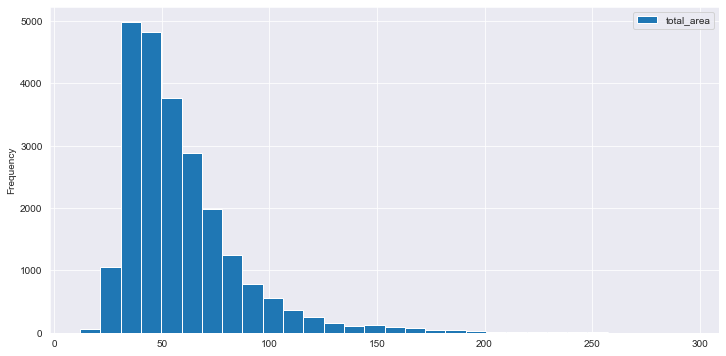

In [22]:
data.plot(kind='hist', y='total_area', grid=True, bins=30, figsize=(12, 6));

На данном графике видим, что основная масса квартир имеет площадь от 25 до 75 квадратных метров, чаще всего квартира будет площадью 30-45 квадратных метров. Крайне редко встречаются квартиры, площадью свыше 200 квадратных метров.

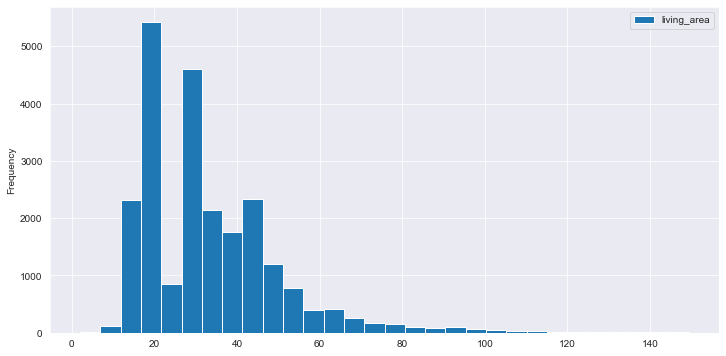

In [23]:
data.plot(kind='hist', y='living_area', grid=True, bins=30, figsize=(12, 6));

Изучив гистограмму можно выяснить, что в основном жилая площадь в квартирах около 20 квадратных метров, либо около 30 квадратных метров, либо около 45-50 квадратных метров. Это можно объяснить ссылаясь на график ниже, что основная масса квартир имеет одну, две или три комнаты, поэтому и видим такие всплески на графике жилой площади.

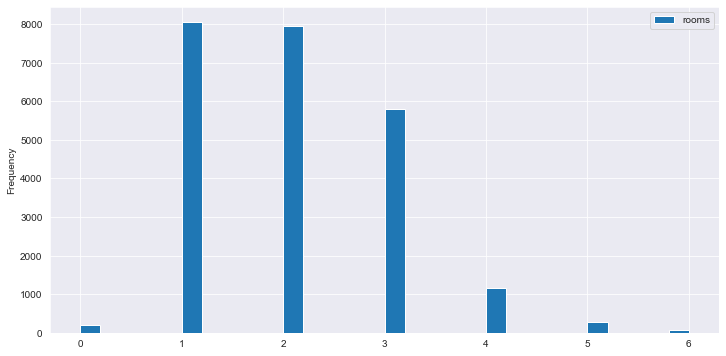

In [24]:
data.plot(kind='hist', y='rooms', grid=True, bins=30, figsize=(12, 6));

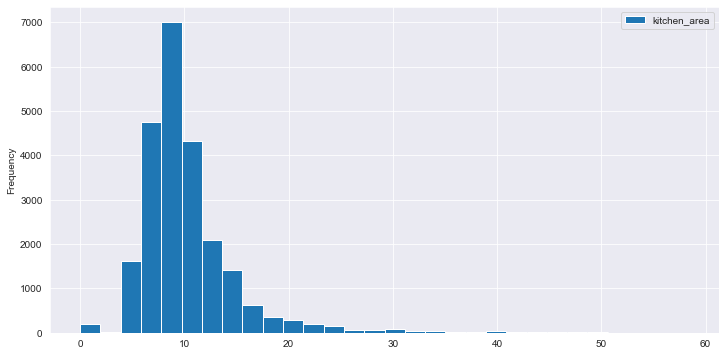

In [25]:
data.plot(kind='hist', y='kitchen_area', grid=True, bins=30, figsize=(12, 6));

На графике видим, что в подавляющем большинстве площадь кухни варьируется от 6 до 12 квадратных метров, также на графике можем наблюдать небольшую группу кухонь с нулевой площадью - это кухни в студиях и квартирах без комнат, где кухня совмещена с жилой комнатой.

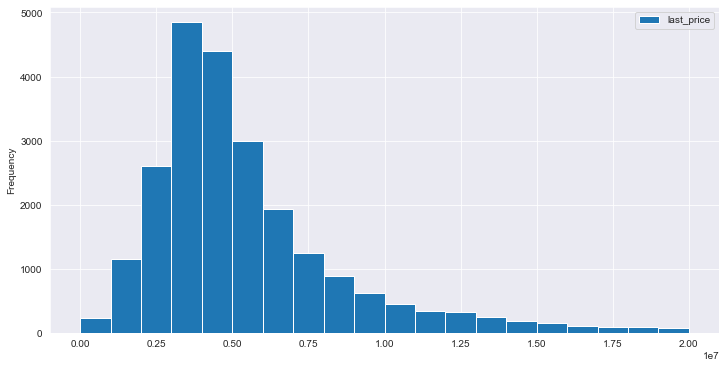

In [26]:
data.plot(kind='hist', y='last_price', grid=True, bins=20, figsize=(12, 6), range=(0,2*10**7));

На гистограмме стимости квартир видим основную массу квартир, которые стоят от 2,5 млн до 6 млн. Реже встречаются квартиры стоимостью 1 - 2,5 млн, а также 6-20 млн.

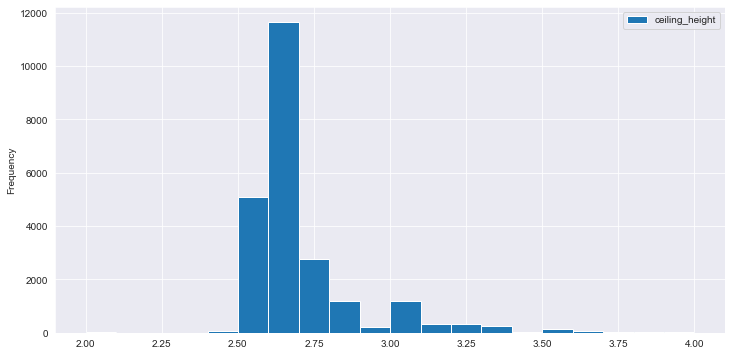

In [27]:
data.plot(kind='hist', y='ceiling_height', grid=True, bins=20, figsize=(12, 6),  range=(2,4));

На графике видим основную массу квартир с высотой потолков 2,5-2,7 метра, реже встречаются потолки 2,8 или 3.1 метра.

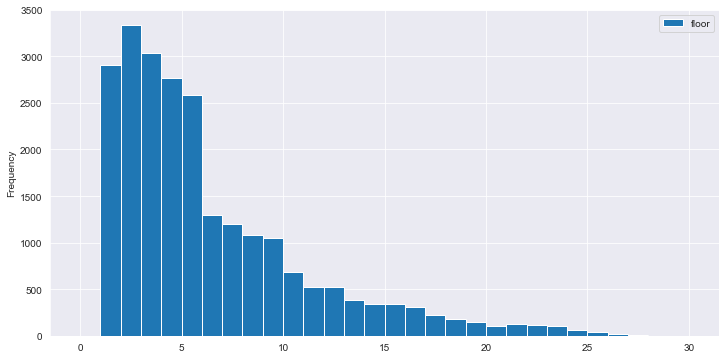

In [28]:
data.plot(kind='hist', y='floor', grid=True, bins=30, figsize=(12, 6), range=(0,30));

На графике этажа квартиры видно, что чаще всего продаются квартиры на этажах с первого по пятый, чуть реже с 5 по 9, это можно обьяснить, посмотрев на график ниже - количество этажей в домах, из него видно, что основная масса жилого фонда - пятиэтажки, реже 9-этажные дома. На графике этажности домов можем также видеть всплески около типовых домов в 12,16 и 25 этажей.

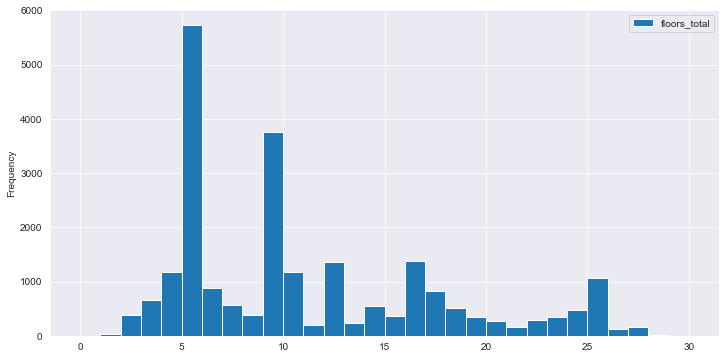

In [29]:
data.plot(kind='hist', y='floors_total', grid=True, bins=30, figsize=(12, 6), range=(0,30));

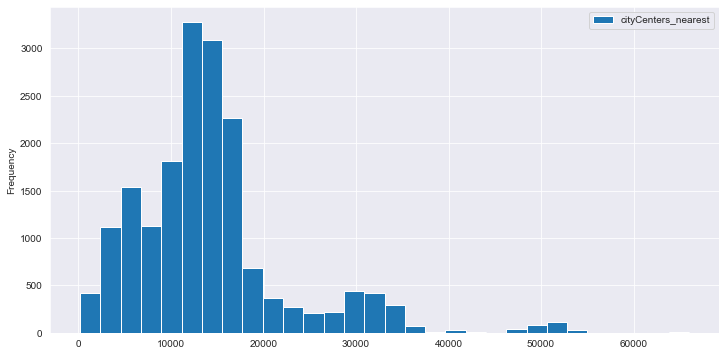

In [30]:
data.plot(kind='hist', y='cityCenters_nearest', grid=True, bins=30, figsize=(12, 6));

Основная масса квартир находится в спальных районах города - в 10-17 километрах от центра. Реже квартиры находятся ближе к центру - от нуля до 10 км. Также можно выделить пригород - 20-35 км от центра.

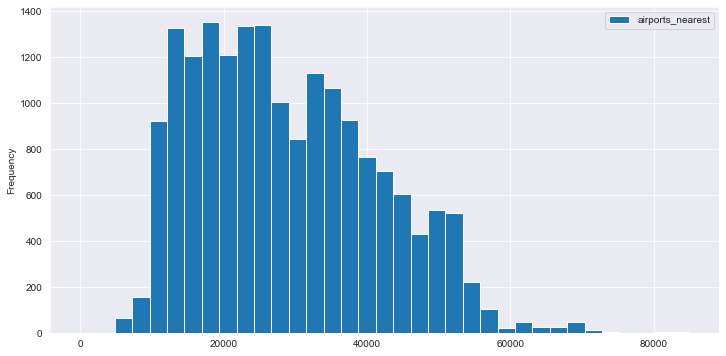

In [31]:
data.plot(kind='hist', y='airports_nearest', grid=True, bins=35, figsize=(12, 6)) ;

На графике видим, что квартиры находятся на удалении 10-40 км от аэропорта, реже 40-55 км.

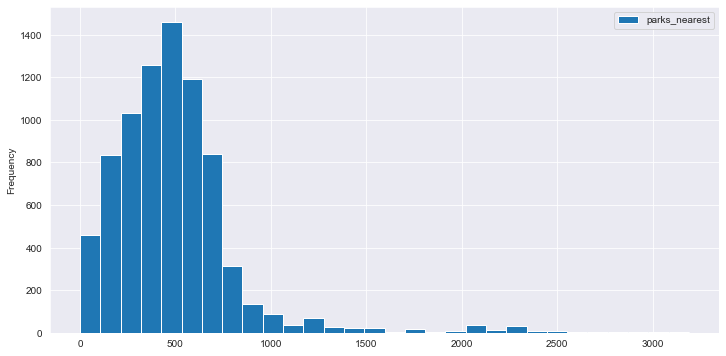

In [32]:
data.plot(kind='hist', y='parks_nearest', grid=True, bins=30, figsize=(12, 6));

Основная масса квартир находится на удалении 100-700м от парка.

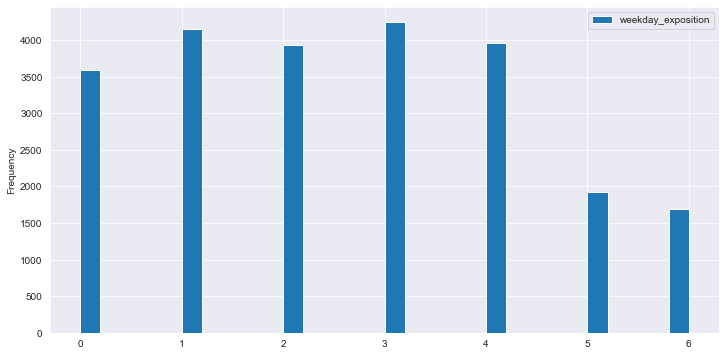

In [33]:
data.plot(kind='hist', y='weekday_exposition', grid=True, bins=30, figsize=(12, 6));

По гистограмме достаточно сложно определить явного лидера среди дней недели, скорее можно сказать, что объявления о продаже квартир выкладываются в будние дни чаще, чем в выходные.

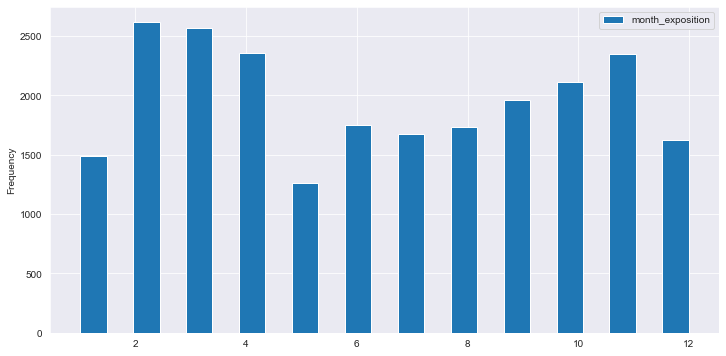

In [34]:
data.plot(kind='hist', y='month_exposition', grid=True, bins=23, figsize=(12, 6));

На гистограмме наблюдаем, что квартиры чаще всего выставляются на продажу зимой и осенью, и чуть реже летом и в мае, что скорее всего связано с праздниками и отпусками.

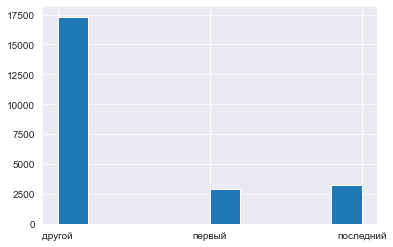

In [35]:
data['floor_type'].hist(grid=True);

Исходя из графика понимаем, что чаще всего продаются квартиры не крайних этажей. При этом квартир не крайних этажей больше по количеству.

Изучим, как быстро продавались квартиры. Этот параметр показывает, сколько дней было размещено каждое объявление.
    - Построим гистограмму.
    - Посчитаем среднее и медиану.

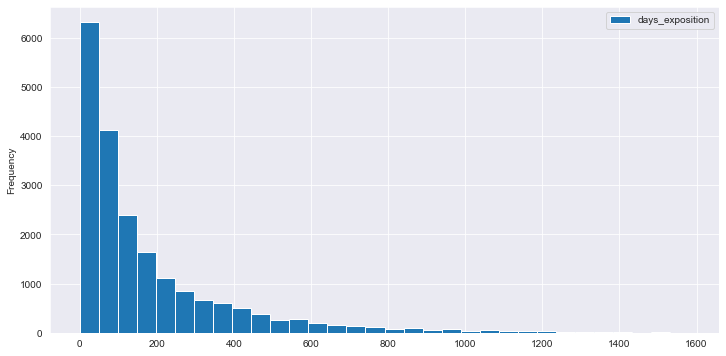

In [36]:
data.plot(kind='hist', y='days_exposition', grid=True, bins=32, figsize=(12, 6));

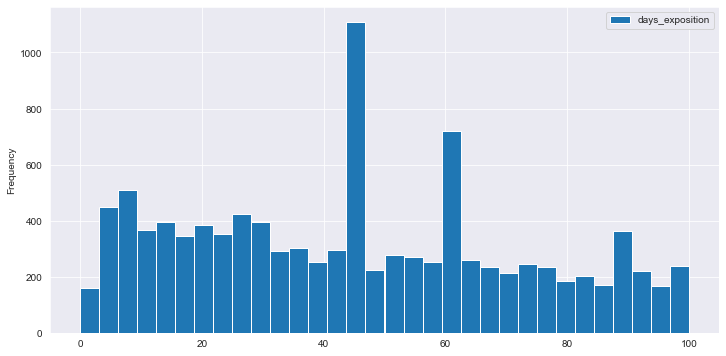

In [37]:
data.plot(kind='hist', y='days_exposition', grid=True, bins=32, figsize=(12, 6), range=(0,100));

In [38]:
print('Среднее', round(data['days_exposition'].mean(),2))
print('Медиана', data['days_exposition'].median())

Среднее 180.17
Медиана 95.0


Опираясь на график и вычисленные данные можно сказать, что обычно продажа занимает около 95 дней (3-4 месяца), а значит быстрыми можно считать продажи, которые произошли в течении первых 2-3 месяцев. Необычно долгие продажи - более 200 дней.

Изучим факторы, которые предположительно больше всего влияют на общую (полную) стоимость объекта:
Зависит ли цена от:
   - общей площади;
   - жилой площади;
   - площади кухни;
   - количества комнат;
   - этажа, на котором расположена квартира (первый, последний, другой);
   - даты размещения (день недели, месяц, год).

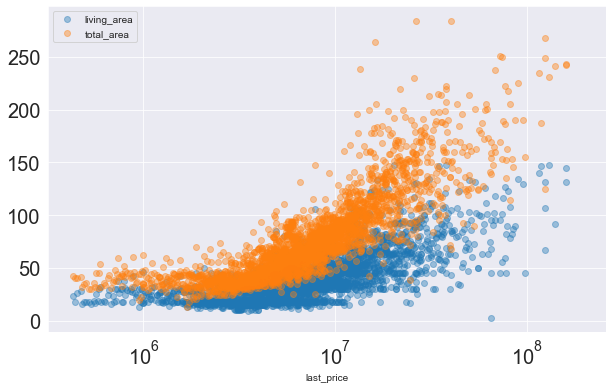

In [39]:
(pd
 .pivot_table(data, values=['total_area', 'living_area'], index='last_price', aggfunc='median')
 .plot(style='o', grid=True, figsize=(10, 6), alpha=0.4, fontsize=20, logx=True, xlim=(10**5.5))
 )
plt.show()

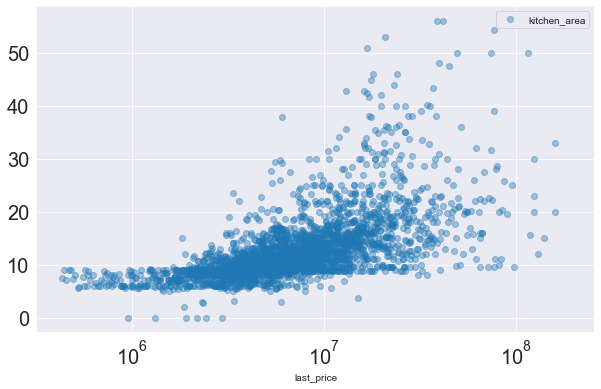

In [40]:
(pd
 .pivot_table(data, values=['kitchen_area'], index='last_price', aggfunc='median')
 .plot(style='o', grid=True, figsize=(10, 6), alpha=0.4, fontsize=20, logx=True, xlim=(10**5.5))
 );

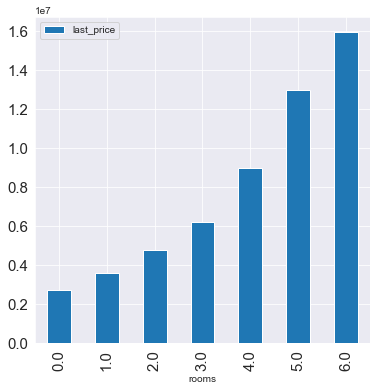

In [41]:
pd.pivot_table(data, values='last_price', index='rooms', aggfunc='median').plot(kind='bar', figsize=(6, 6), fontsize=15);

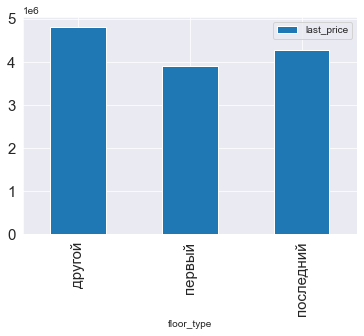

In [42]:
pd.pivot_table(data, values='last_price', index='floor_type', aggfunc='median').plot(kind='bar', figsize=(6, 4), fontsize=15);

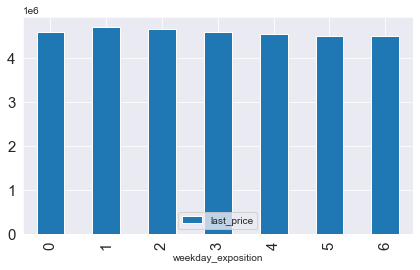

In [43]:
pd.pivot_table(data, values='last_price', index='weekday_exposition', aggfunc='median').plot(kind='bar', figsize=(7,4), fontsize=15);

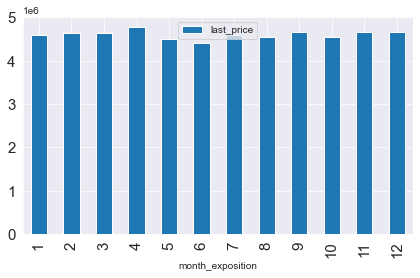

In [44]:
pd.pivot_table(data, values='last_price', index='month_exposition', aggfunc='median').plot(kind='bar', figsize=(7, 4), fontsize=15);

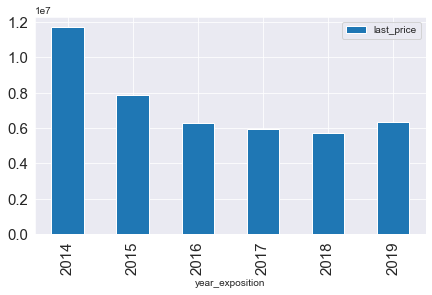

In [45]:
pd.pivot_table(data, values='last_price', index='year_exposition', aggfunc='mean').plot(kind='bar', figsize=(7, 4), fontsize=15);

Изучив построенные графики можно придти к выводу, что больше всего на общую (полную) стоимость объекта влияют полная площадь квартиры, а также площадь жилой зоны и кухни.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

,count,mean
locality_name_filtered,,
санкт-петербург,15522,113523.45
мурино,590,86087.51
кудрово,471,95319.26
шушары,440,78677.36
всеволожск,398,68654.48
пушкин,364,102929.68
колпино,337,75333.30
парголово,326,90332.26
гатчина,307,68746.15


Максимальная стоимость квадратного метра: 113523.45
Минимальная стоимость квадратного метра: 58141.91


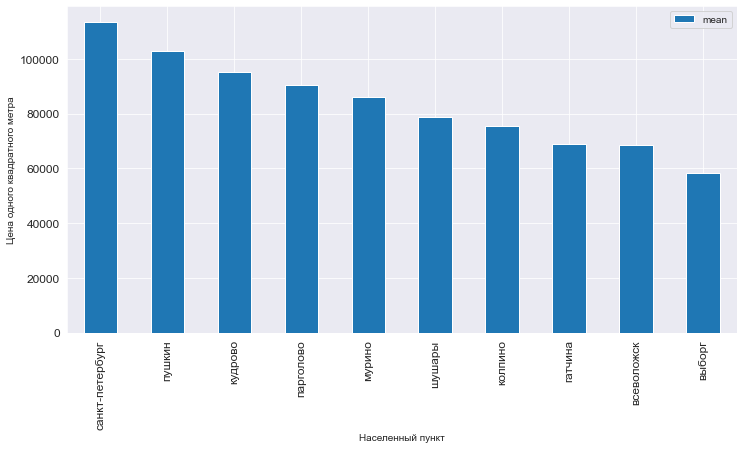

In [46]:
top10 = data.pivot_table(index='locality_name_filtered'
                         , values='one_meter_area_price'
                         , aggfunc=('count','mean')).sort_values(by='count', ascending=False).head(10)

top10['mean'] = round(top10['mean'],2)
display(top10)
print(f'Максимальная стоимость квадратного метра: {top10["mean"].max()}')
print(f'Минимальная стоимость квадратного метра: {top10["mean"].min()}')

top10.sort_values('mean',ascending=False).plot(kind='bar', y='mean' , grid=True, figsize=(12, 6), ylabel='Цена одного квадратного метра', xlabel='Населенный пункт', fontsize = 12)
plt.xticks(rotation='vertical')
plt.show()

Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра.

,count,mean,onekm_price
kilometres_to_cityCenter,,,
0.0,23,2.207311e+07,inf
1.0,173,1.501358e+07,1.501358e+07
2.0,292,1.520983e+07,7.604915e+06
3.0,336,1.020879e+07,3.402930e+06
4.0,669,1.126495e+07,2.816239e+06
5.0,877,1.192619e+07,2.385238e+06
6.0,581,1.241938e+07,2.069897e+06
7.0,411,1.373624e+07,1.962320e+06
8.0,592,9.040130e+06,1.130016e+06


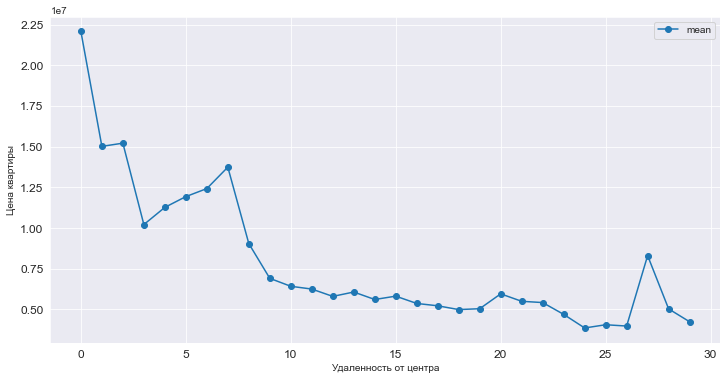

In [47]:
spb_price_km = data.loc[data['locality_name_filtered'] == 'санкт-петербург'].pivot_table(index='kilometres_to_cityCenter'
                         , values='last_price'
                         , aggfunc=('count','mean'))
try:
    spb_price_km['onekm_price'] = spb_price_km['mean'] / spb_price_km.index
except:
    print('division by zero!')
display(spb_price_km)


spb_price_km.plot(style='o-', y='mean' , grid=True, figsize=(12, 6), ylabel='Цена квартиры', xlabel='Удаленность от центра', fontsize = 12);

Получив график стоимости квартир в Санкт-Петербурге в зависимости от удаленности центра можно сделать вывод:
Чем квартира находится ближе к центру, тем дороже стоит. При этом, можно увидеть на графике небольшой всплеск - скорее всего это влияние района и площади квартиры на цену, которые перебивают удаленность от центра.

### Общий вывод

В ходе исследования были выявлены несколько зависимостей:
 - Зависимость цены от удаленности центра города - чем ближе квартира находится к центру города, тем дороже
 - Зависимость цены от площади квартиры (общей, жилой, площади кухни)
 - Зависимость цены квартиры от города - в Санкт-Петербурге самые дорогие квартиры, в городах спутниках цены ниже
 - Зависимость цены квартиры от количества комнат - чем больше комнат, тем дороже

Также, было выяснено, что обычно продажа занимает около 95 дней (3-4 месяца), 2-3 месяца можно считать быстрой продажей, а полгода и больше - долгой.
При этом, чаще всего объявления о продаже выкладываются в будние дни.

Таким образом, средняя типичная квартира будет:
 - площадью 30-35 квадратных метров
 - однокомнатная
 - кухня 6 квадратных метров
 - стоимость около 3 млн
 - 1-3 этаж 5-этажного дома
 - 10-15 километров до центра
 - до ближайшего парка 500 метров